In [1]:
from plotnine import *
import plotnine as plotnine
import pandas as pd
import math

In [194]:
df = pd.concat([
    pd.read_csv('block_linux_x86_64.csv'),
    pd.read_csv('block_bufchan_linux_x86_64.csv'),
])
df['workload'] = [
    r['workload'] if r['workload'] != 'chan' else 'chan(cap={})'.format(r['bufsize'])
    for _, r in df.iterrows()
]
df['blockprofilerate'] = [('10$^{'+str(int(math.log10(x)))+'}$') if x > 1 else str(x) for x in df['blockprofilerate']]

compare = df.groupby(['blockprofilerate', 'workload']).median()
# calculate overhead compared to blockprofilerate=0 for same workload
compare['overhead'] = [
    (x['ms'] / compare.loc['0'].loc[x['workload']]['ms'] - 1) * 100
    for _, x in compare.reset_index().iterrows()
]
compare = compare.reset_index()

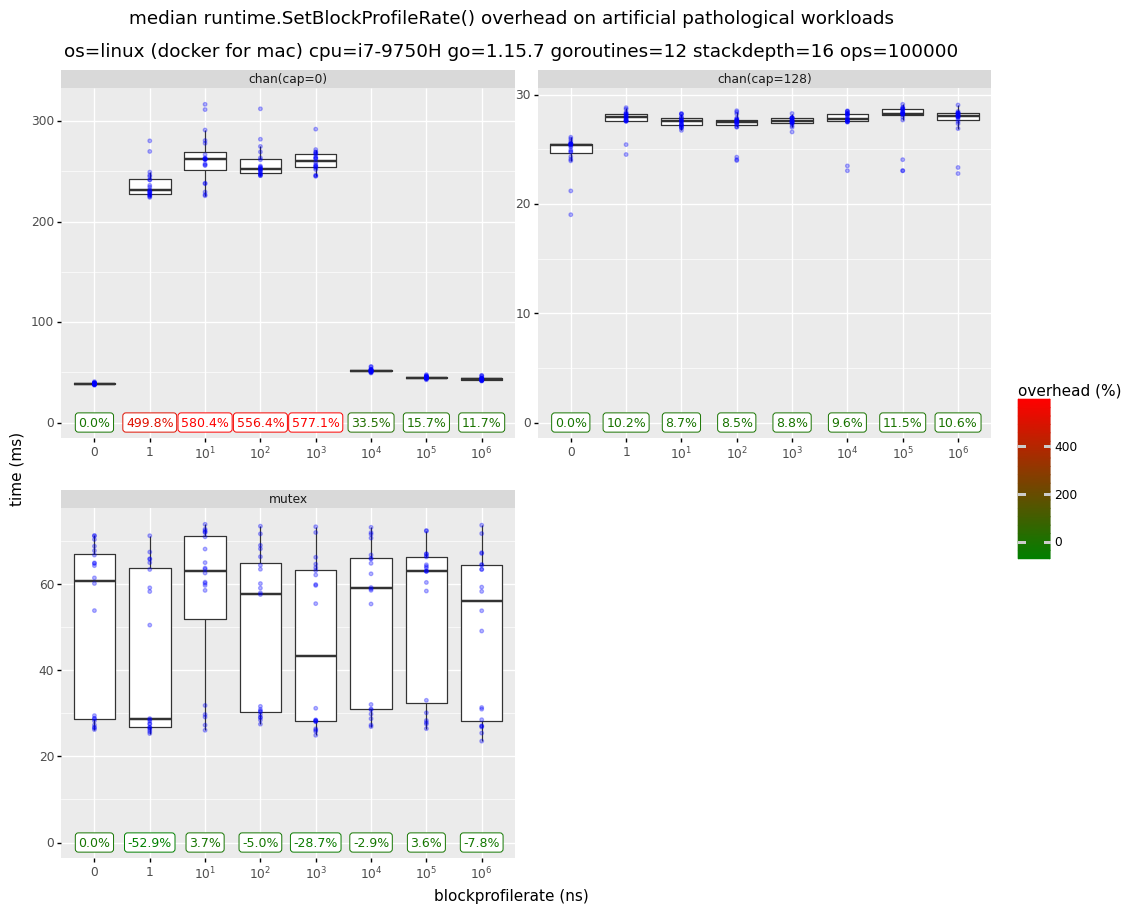

<ggplot: (335455735)>

In [201]:
plotnine.options.figure_size = (12, 10)

def plot_title(df):
    return (
        'median runtime.SetBlockProfileRate() overhead on artificial pathological workloads\n\n' +
        'os={} cpu={} go={} goroutines={} stackdepth={} ops={}'.format(
            # TODO(fg) don't hard code environment
            'linux (docker for mac)',
            'i7-9750H',
            '1.15.7',
            val_range(df, 'goroutines'),
            val_range(df, 'depth'),
#             val_range(df, 'bufsize'),
            val_range(df, 'ops'),
        )
    )

def val_range(df, col):
    min = int(df[col].min())
    max = int(df[col].max())
    return '{}-{}'.format(min, max) if min != max else min

(
ggplot(df)
+ aes(x='blockprofilerate',y='ms',ymin=0)
+ ggtitle(plot_title(compare))
+ ylab('time (ms)')
+ xlab('blockprofilerate (ns)')
+ geom_label(
    aes(label='overhead',color='overhead'),
    data=compare,
    y=0,
    size=9,
    format_string='{:.1f}%'
)
+ scale_color_gradient(low="green",high="red",name='overhead (%)')
+ geom_boxplot(outlier_shape='')
+ facet_wrap('workload', scales='free', ncol=2)
+ theme(subplots_adjust={'wspace': 0.05, 'hspace': 0.2})
+ geom_point(color='blue',shape='o',alpha=0.3, size=1)
)